# Visualizer and Plotter

Notebook to create the images used in the report


In [2]:
from dataset import CHBMITDataset

data_path = "./CHB-MIT/processed"
dataset = CHBMITDataset(data_path)

In [3]:
from torch.utils.data import DataLoader

data_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

time_steps = np.arange(0, 128, 1)
noise = np.random.normal(0, 0.1, size=time_steps.shape)
signal = np.sin(((2 * np.pi / 64) * (time_steps - 16))) + noise

# Normalize signal between 0 and 1 to represent firing probability
normalized_data = (signal - signal.min()) / (signal.max() - signal.min())

In [ ]:
def rate_encode(data: np.ndarray, interval_freq=8, seed=49):
    # Oversample the data to simulate higher temporal resolution
    oversampled_prob = data.repeat(interval_freq)

    # Generate random values to compare against firing probabilities
    np.random.seed(seed)
    random_thresholds = np.random.uniform(0, 1, oversampled_prob.shape)

    # Generate spikes (1) when random value is less than firing probability
    spikes = np.where(random_thresholds < oversampled_prob, 1, 0)

    # Reshape spike train to decode (group by original time steps)
    spike_windows = spikes.reshape(-1, interval_freq)

    # Decode using mean firing rate (Maximum Likelihood Estimation)
    decoded_signal = spike_windows.mean(axis=1)

    return spikes, decoded_signal

In [ ]:
import optuna


def objective(trial: optuna.Trial) -> float:
    interval_freq = trial.suggest_int("interval_freq", 1, 8)
    seed = trial.suggest_int("seed", 0, 100)
    _, decoded_signal = rate_encode(
        normalized_data, interval_freq=interval_freq, seed=seed
    )

    # Calculate the mean squared error between the original and decoded signal
    mse = np.mean((decoded_signal - normalized_data) ** 2)
    return mse


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2025-04-06 17:34:25,218] A new study created in memory with name: no-name-8c9a5b92-d635-4405-96de-2dfa10cc612b
[I 2025-04-06 17:34:25,220] Trial 0 finished with value: 0.03278491023210577 and parameters: {'interval_freq': 6, 'seed': 46}. Best is trial 0 with value: 0.03278491023210577.
[I 2025-04-06 17:34:25,221] Trial 1 finished with value: 0.053353347496121854 and parameters: {'interval_freq': 3, 'seed': 90}. Best is trial 0 with value: 0.03278491023210577.
[I 2025-04-06 17:34:25,223] Trial 2 finished with value: 0.056821028133735366 and parameters: {'interval_freq': 3, 'seed': 20}. Best is trial 0 with value: 0.03278491023210577.
[I 2025-04-06 17:34:25,225] Trial 3 finished with value: 0.06025805790206202 and parameters: {'interval_freq': 3, 'seed': 38}. Best is trial 0 with value: 0.03278491023210577.
[I 2025-04-06 17:34:25,226] Trial 4 finished with value: 0.041701241801064215 and parameters: {'interval_freq': 4, 'seed': 87}. Best is trial 0 with value: 0.03278491023210577.
[I 

In [7]:
study.best_params

NameError: name 'study' is not defined

In [ ]:
rate_spikes, decoded_rate = rate_encode(
    normalized_data,
    interval_freq=study.best_params["interval_freq"],
    seed=study.best_params["seed"],
)

<Axes: title={'center': 'Decoded Signal'}, xlabel='Timesteps', ylabel='Amplitude'>

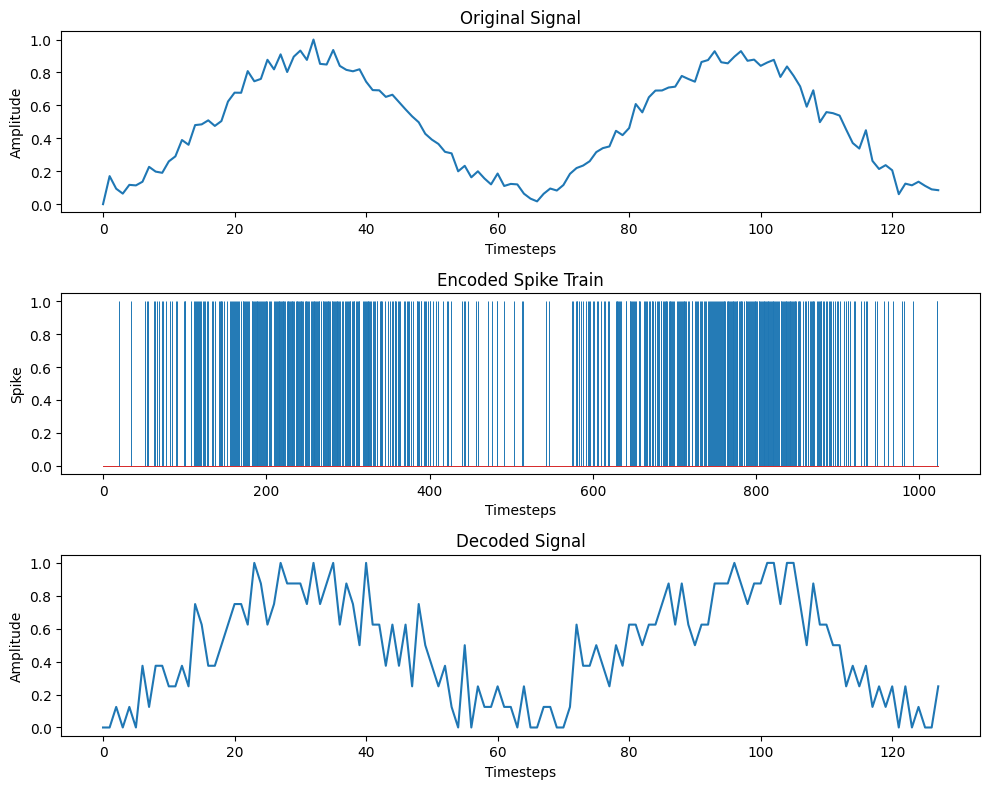

In [ ]:
figs, axes = plt.subplots(3, 1, figsize=(10, 8))
figs.set_tight_layout(True)
axes[0].set_title("Original Signal")
axes[0].set_xlabel("Timesteps")
axes[0].set_ylabel("Amplitude")
sns.lineplot(normalized_data, ax=axes[0])
axes[1].set_title("Encoded Spike Train")
axes[1].set_xlabel("Timesteps")
axes[1].set_ylabel("Spike")
stemline = axes[1].stem(rate_spikes, markerfmt="none")
plt.setp(stemline, "linewidth", 0.7)
axes[2].set_title("Decoded Signal")
axes[2].set_xlabel("Timesteps")
axes[2].set_ylabel("Amplitude")
sns.lineplot(decoded_rate, ax=axes[2])

In [ ]:
def step_encoding(data, threshold):
    step_spikes = np.zeros_like(data)
    encoding_base = data[0]

    for t in range(1, data.shape[0]):
        if data[t] >= encoding_base + threshold:
            step_spikes[t] = 1
            encoding_base += threshold
        elif data[t] <= encoding_base - threshold:
            step_spikes[t] = -1
            encoding_base -= threshold

    # Decoding phase
    decoding_base = data[0]
    step_decoded = np.zeros_like(step_spikes)
    step_decoded[0] = decoding_base  # Initialize first value

    for t in range(1, step_spikes.shape[0]):
        if step_spikes[t] == 1:
            decoding_base += threshold
        elif step_spikes[t] == -1:
            decoding_base -= threshold

        step_decoded[t] = decoding_base

    return step_spikes, step_decoded


In [ ]:
import optuna


def objective(trial: optuna.Trial) -> float:
    # Parameters
    threshold = trial.suggest_float("threshold", 0.01, 0.4)

    _, decoded = step_encoding(normalized_data, threshold)

    # Calculate loss (Mean Squared Error)
    loss = np.mean((decoded - normalized_data) ** 2)
    return loss


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)
print("Best trial:", study.best_trial)

[I 2025-04-22 01:19:38,895] A new study created in memory with name: no-name-04f64443-8d43-4db7-893f-be5d1d1c6873
[I 2025-04-22 01:19:38,898] Trial 0 finished with value: 0.03474825185698192 and parameters: {'threshold': 0.368032867024365}. Best is trial 0 with value: 0.03474825185698192.
[I 2025-04-22 01:19:38,899] Trial 1 finished with value: 0.0031543630623647317 and parameters: {'threshold': 0.10264802903314846}. Best is trial 1 with value: 0.0031543630623647317.
[I 2025-04-22 01:19:38,899] Trial 2 finished with value: 0.02193734235358112 and parameters: {'threshold': 0.2901288471522072}. Best is trial 1 with value: 0.0031543630623647317.
[I 2025-04-22 01:19:38,899] Trial 3 finished with value: 0.04174525875607914 and parameters: {'threshold': 0.02124647129652127}. Best is trial 1 with value: 0.0031543630623647317.
[I 2025-04-22 01:19:38,900] Trial 4 finished with value: 0.0021226833841275347 and parameters: {'threshold': 0.0623167489549114}. Best is trial 4 with value: 0.002122683

Best trial: FrozenTrial(number=41, state=1, values=[0.0015988060656589374], datetime_start=datetime.datetime(2025, 4, 22, 1, 19, 39, 21169), datetime_complete=datetime.datetime(2025, 4, 22, 1, 19, 39, 24349), params={'threshold': 0.06966743786324561}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'threshold': FloatDistribution(high=0.4, log=False, low=0.01, step=None)}, trial_id=41, value=None)


In [10]:
threshold = 0.06966743786324561

step_spikes, step_decoded = step_encoding(normalized_data, threshold)

In [ ]:
import torch


def normalize(x: torch.Tensor, axis=None) -> torch.Tensor:
    """
    Normalize the input tensor to the range [0, 1].

    Args:
        x (torch.Tensor): Input tensor to be normalized.
        axis (int, optional): Axis along which to normalize the tensor. If None, global normalization is applied.

    Returns:
        torch.Tensor: Normalized tensor.
    """
    if axis is None:
        x_min = x.min()
        x_max = x.max()

        if x_min == x_max:
            return torch.zeros_like(x)
        return (x - x_min) / (x_max - x_min)

    if axis < 0:
        axis = x.dim() + axis

    x_min = x.min(dim=axis, keepdim=True)
    x_max = x.max(dim=axis, keepdim=True)

    print("Min", x_min.values)
    print("Max", x_max.values)

    diff = x_max.values - x_min.values
    diff[diff == 0] = 1

    return (x - x_min.values) / diff

In [20]:
# Example usage for 2D tensor
test = torch.tensor([[1, 2, 3], [3, 4, 9], [5, 6, 27]]).float()
normalized_test = normalize(test, axis=0)
print("Normalized tensor:\n", test)
print("Minimum value:\n", normalized_test)

Min tensor([[1., 2., 3.]])
Max tensor([[ 5.,  6., 27.]])
Normalized tensor:
 tensor([[ 1.,  2.,  3.],
        [ 3.,  4.,  9.],
        [ 5.,  6., 27.]])
Minimum value:
 tensor([[0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.2500],
        [1.0000, 1.0000, 1.0000]])


In [ ]:
test = torch.tensor()
print(normalize(test))

tensor([0.0000, 0.0526, 0.1053, 0.1579, 1.0000])


<Axes: title={'center': 'Decoded Signal'}, xlabel='Timesteps', ylabel='Amplitude'>

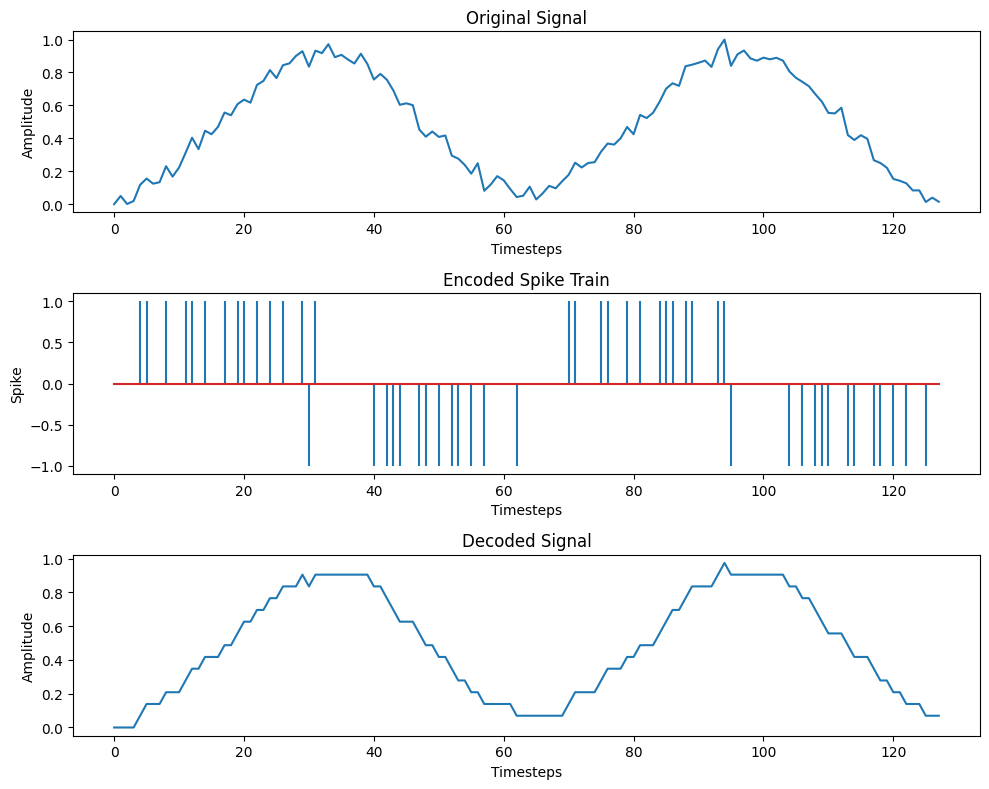

In [11]:
figs, axes = plt.subplots(3, 1, figsize=(10, 8))
figs.set_tight_layout(True)
axes[0].set_title("Original Signal")
axes[0].set_xlabel("Timesteps")
axes[0].set_ylabel("Amplitude")
sns.lineplot(normalized_data, ax=axes[0])
axes[1].set_title("Encoded Spike Train")
axes[1].set_xlabel("Timesteps")
axes[1].set_ylabel("Spike")
stemline = axes[1].stem(step_spikes, markerfmt="none")
axes[2].set_title("Decoded Signal")
axes[2].set_xlabel("Timesteps")
axes[2].set_ylabel("Amplitude")
sns.lineplot(step_decoded, ax=axes[2])

In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

test_data = torch.rand(32, 22, 128, 64)
test_data

tensor([[[[0.3628, 0.7932, 0.0162,  ..., 0.4789, 0.1497, 0.2169],
          [0.5599, 0.1706, 0.4472,  ..., 0.5036, 0.4828, 0.3544],
          [0.5614, 0.2747, 0.4430,  ..., 0.2954, 0.1353, 0.1033],
          ...,
          [0.4901, 0.8691, 0.0451,  ..., 0.0023, 0.7085, 0.2917],
          [0.1927, 0.5546, 0.7250,  ..., 0.0276, 0.2019, 0.3518],
          [0.9869, 0.3373, 0.5849,  ..., 0.8556, 0.4277, 0.4554]],

         [[0.9520, 0.1548, 0.1734,  ..., 0.9791, 0.7013, 0.8406],
          [0.5747, 0.9036, 0.6514,  ..., 0.8659, 0.4665, 0.8074],
          [0.2999, 0.6627, 0.1474,  ..., 0.2224, 0.8885, 0.6487],
          ...,
          [0.9937, 0.5570, 0.2848,  ..., 0.9396, 0.8047, 0.7954],
          [0.4289, 0.6459, 0.8950,  ..., 0.6268, 0.9243, 0.4781],
          [0.4461, 0.2162, 0.2529,  ..., 0.5903, 0.6027, 0.8546]],

         [[0.4845, 0.5174, 0.2446,  ..., 0.0234, 0.5274, 0.3928],
          [0.9205, 0.9160, 0.3913,  ..., 0.7615, 0.9972, 0.2108],
          [0.9135, 0.5375, 0.8295,  ..., 0

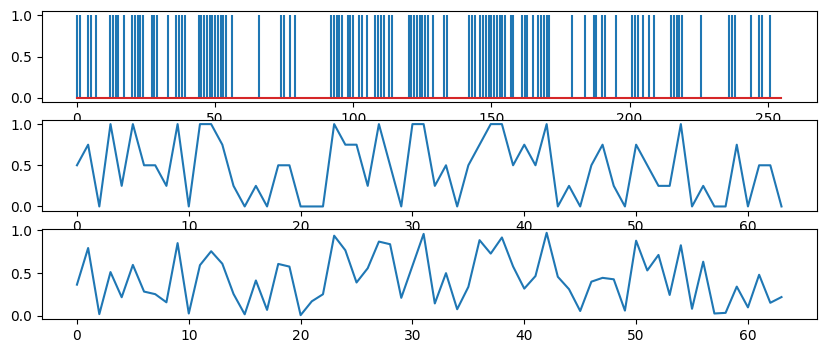

In [10]:
from encoder.rate import PoissonEncoder

p_encoder = PoissonEncoder(interval_freq=4, random_seed=47)
encoded_data = p_encoder.encode(test_data)
decoded_rate = p_encoder.decode(encoded_data)

fig, axes = plt.subplots(3, 1, figsize=(10, 4))
axes[0].stem(encoded_data[0, 0, 0, :], markerfmt="none")
axes[1].plot(decoded_rate[0, 0, 0, :])
axes[2].plot(test_data[0, 0, 0, :])

In [ ]:
from encoder.temporal import StepForwardEncoder

step_encoder = StepForwardEncoder(threshold=0.3161534068178387)

encoded_data = step_encoder.encode(test_data)
print(encoded_data)

tensor([[[[ 0.,  0., -1.,  ...,  0.,  1.,  0.],
          [ 0., -1.,  0.,  ...,  0.,  0., -1.],
          [ 0.,  1.,  0.,  ...,  0.,  1., -1.],
          ...,
          [ 0.,  0.,  0.,  ...,  1., -1.,  0.],
          [ 0.,  0.,  1.,  ...,  0.,  0.,  1.],
          [ 0., -1.,  0.,  ..., -1.,  1.,  0.]],

         [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0., -1.,  0.],
          [ 0., -1., -1.,  ...,  0.,  0.,  0.],
          ...,
          [ 0.,  0., -1.,  ...,  1.,  0., -1.],
          [ 0.,  1.,  1.,  ...,  0.,  1.,  0.],
          [ 0.,  0.,  1.,  ...,  0.,  1.,  1.]],

         [[ 0.,  0.,  0.,  ...,  1.,  1.,  0.],
          [ 0.,  0.,  0.,  ..., -1.,  1.,  0.],
          [ 0., -1., -1.,  ...,  0.,  0., -1.],
          ...,
          [ 0., -1.,  0.,  ...,  0.,  0.,  1.],
          [ 0., -1.,  1.,  ...,  1., -1.,  1.],
          [ 0., -1., -1.,  ...,  1., -1., -1.]],

         ...,

         [[ 0.,  0.,  0.,  ...,  0.,  0.,  1.],
          [ 0.,  0.,  

In [ ]:
import optuna

def objective(trial: optuna.Trial) -> float:
    # Parameters
    threshold = trial.suggest_float("threshold", 0.27, 0.37)

    step_encoder = StepForwardEncoder(threshold=threshold)

    encoded_data = step_encoder.encode(test_data)

    base = test_data.select(-1, 0)
    decoded_data = step_encoder.decode(encoded_data, base=base)

    loss = torch.nn.functional.mse_loss(decoded_data, test_data)
    return loss.item()

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2025-04-26 00:11:58,948] A new study created in memory with name: no-name-dae47c97-78d5-4ca8-9dcd-06f292a58c0d
[I 2025-04-26 00:11:59,199] Trial 0 finished with value: 0.039106354117393494 and parameters: {'threshold': 0.2736416412064265}. Best is trial 0 with value: 0.039106354117393494.
[I 2025-04-26 00:11:59,389] Trial 1 finished with value: 0.03824964538216591 and parameters: {'threshold': 0.306490548962004}. Best is trial 1 with value: 0.03824964538216591.
[I 2025-04-26 00:11:59,572] Trial 2 finished with value: 0.03912830725312233 and parameters: {'threshold': 0.2729605446781127}. Best is trial 1 with value: 0.03824964538216591.
[I 2025-04-26 00:11:59,755] Trial 3 finished with value: 0.0387115478515625 and parameters: {'threshold': 0.34688620859812125}. Best is trial 1 with value: 0.03824964538216591.
[I 2025-04-26 00:11:59,922] Trial 4 finished with value: 0.038799021393060684 and parameters: {'threshold': 0.3485893880908595}. Best is trial 1 with value: 0.03824964538216591.

In [17]:
based = test_data.select(-1, 0)
decoded_step = step_encoder.decode(encoded_data, base=based)

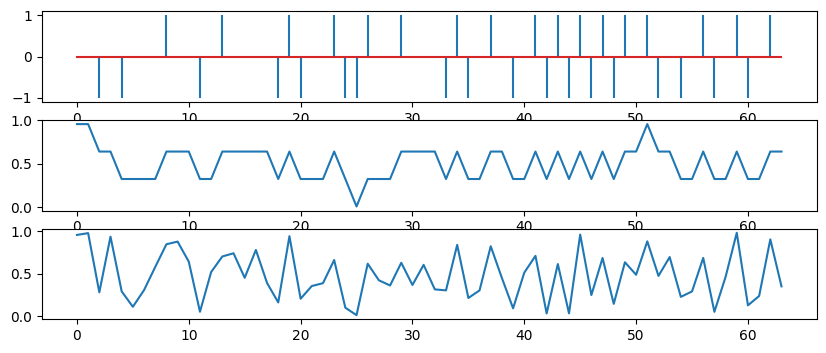

In [18]:
fig, axes = plt.subplots(3, 1, figsize=(10, 4))
axes[0].stem(encoded_data[0, 0, 0, :], markerfmt="none")
axes[1].plot(decoded_step[0, 0, 0, :])
axes[2].plot(test_data[0, 0, 0, :])

In [2]:
import torch
from scipy import signal

filter_w = signal.firwin(3, cutoff=0.2)
filter_w = torch.tensor(filter_w, dtype=torch.float32)
filter_w

tensor([0.0651, 0.8698, 0.0651])

In [15]:
import numpy as np


def bsa_encode(data, win_size=8, cutoff=0.2, threshold=0.95):
    # Create filter window
    filter_window = signal.firwin(win_size, cutoff=cutoff)

    # Encoding
    signal_length = data.shape[0]
    bsa_spikes = np.zeros_like(data)
    signal_copy = np.copy(data)

    for t in range(signal_length - win_size + 1):
        error1 = 0
        error2 = 0

        for k in range(win_size):
            error1 += np.abs(signal_copy[t + k] - filter_window[k])
            error2 += np.abs(signal_copy[t + k])

        if error1 <= error2 - threshold:
            bsa_spikes[t] = 1
            for k in range(win_size):
                if t + k < signal_length:
                    signal_copy[t + k] -= filter_window[k]

    return bsa_spikes


In [19]:
import numpy as np

batch, channels, freqs, time_steps = test_data.shape
spikes = np.zeros_like(test_data)

for b in range(batch):
        for c in range(channels):
            for f in range(freqs):
                signal_1d = test_data[b, c, f]
                spikes[b, c, f] = bsa_encode(signal_1d, 8, 0.2, 0.95)

spikes


array([[[[1., 1., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 1., ..., 0., 0., 0.],
         ...,
         [1., 1., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[1., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 0.],
         ...,
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [1., 1., 0., ..., 0., 0., 0.],
    

In [ ]:
x = torch.tensor([[1, 2, 3, 4, 5], [1, 2, 3, 4, 5]])
x.unfold

In [ ]:
import optuna

def objective(trial: optuna.Trial) -> float:
    winsize = trial.suggest_int("win_size", 1, 16)
    cutoff = trial.suggest_float("cutoff", 0.01, 1)
    threshold = trial.suggest_float("threshold", 0.01, 1)

    length = test_data.shape[1] # length of other axis not time axis
    out = []
    for i in range(length):
        bsa_spike = bsa_encode(
            test_data.select(1, i), win_size=winsize, cutoff=cutoff, threshold=threshold
        )
        out.append(torch.tensor(bsa_spike, dtype=torch.float32))

    out = torch.stack(out, dim=0).T

    re_out = []
    filter_w = signal.firwin(winsize, cutoff=cutoff)

    for i in range(length):
        re_out.append(
            torch.tensor(np.convolve(out[:, i], filter_w, mode="same"))
        )
    re_out = torch.stack(re_out, dim=1)

    test = (re_out - test_data) ** 2

    loss = np.average(test)
    return loss

    
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2025-04-25 00:56:10,899] A new study created in memory with name: no-name-6bdb2df6-6fbe-4d41-8ada-7dac0cb68f63
[I 2025-04-25 00:56:10,935] Trial 0 finished with value: 0.3186271212868402 and parameters: {'win_size': 7, 'cutoff': 0.9712216610646554, 'threshold': 0.5926379196994259}. Best is trial 0 with value: 0.3186271212868402.
[I 2025-04-25 00:56:10,963] Trial 1 finished with value: 0.14549106143675908 and parameters: {'win_size': 5, 'cutoff': 0.10679327517973344, 'threshold': 0.4587774038125024}. Best is trial 1 with value: 0.14549106143675908.
[I 2025-04-25 00:56:10,993] Trial 2 finished with value: 0.2310469726087152 and parameters: {'win_size': 6, 'cutoff': 0.9763759001047329, 'threshold': 0.3223290655958896}. Best is trial 1 with value: 0.14549106143675908.
[I 2025-04-25 00:56:11,006] Trial 3 finished with value: 0.07171412002041848 and parameters: {'win_size': 2, 'cutoff': 0.5329377859784615, 'threshold': 0.4645557364516445}. Best is trial 3 with value: 0.07171412002041848.


In [50]:
study.best_params

{'win_size': 2, 'cutoff': 0.494064506594732, 'threshold': 0.17786826554175952}

In [51]:
length = test_data.shape[1] # length of other axis not time axis
out = []
for i in range(length):
    bsa_spike = bsa_encode(
        test_data.select(1, i), win_size=2, cutoff=0.494064506594732, threshold=0.17786826554175952
    )
    out.append(torch.tensor(bsa_spike, dtype=torch.float32))

out = torch.stack(out, dim=0).T

re_out = []
filter_w = signal.firwin(2, cutoff=0.494064506594732)

for i in range(length):
    re_out.append(
        torch.tensor(np.convolve(out[:, i], filter_w, mode="same"))
    )
re_out = torch.stack(re_out, dim=1)

<Axes: >

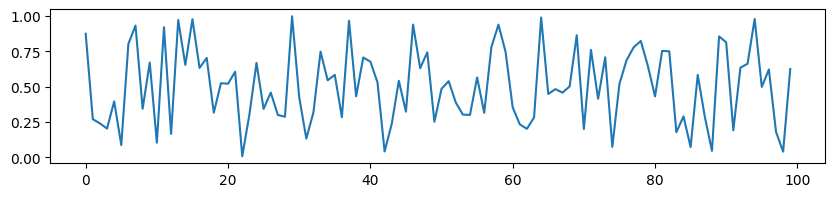

In [52]:
plt.figure(figsize=(10, 2))
sns.lineplot(test_data[:, 0])

<Axes: >

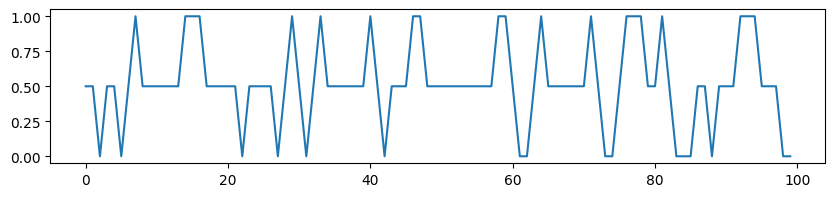

In [56]:

plt.figure(figsize=(10, 2))
sns.lineplot(re_out[:, 0])

<StemContainer object of 3 artists>

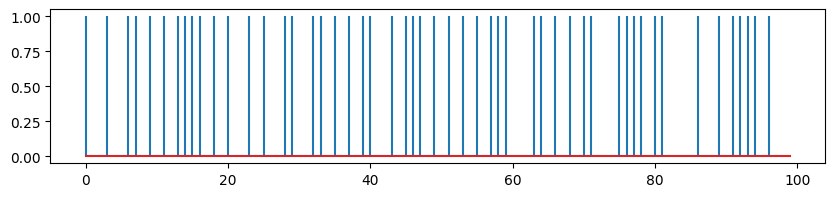

In [53]:
plt.figure(figsize=(10, 2))
plt.stem(out[:, 0], markerfmt="none")

In [54]:
out.T.shape

torch.Size([20, 100])

<Axes: >

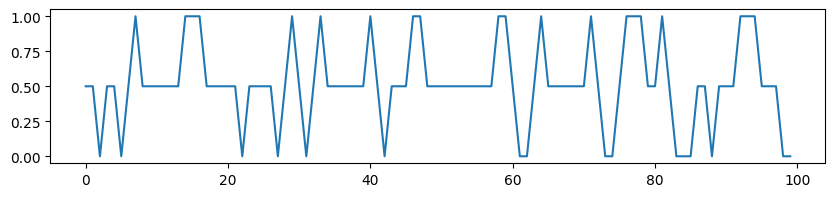

In [ ]:
from scipy import signal


def bsa_encode_decode(data, win_size=8, cutoff=0.2, threshold=0.95):
    # Create filter window
    filter_window = signal.firwin(win_size, cutoff=cutoff)

    # Encoding
    signal_length = data.shape[0]
    bsa_spikes = np.zeros_like(data)
    signal_copy = np.copy(data)

    for t in range(signal_length - win_size + 1):
        error1 = 0
        error2 = 0

        for k in range(win_size):
            error1 += np.abs(signal_copy[t + k] - filter_window[k])
            error2 += np.abs(signal_copy[t + k])

        if error1 <= error2 - threshold:
            bsa_spikes[t] = 1
            for k in range(win_size):
                if t + k < signal_length:
                    signal_copy[t + k] -= filter_window[k]

    # Decoding
    reconstructed = np.convolve(bsa_spikes, filter_window, mode="full")
    reconstructed = reconstructed[:signal_length]

    return bsa_spikes, reconstructed

In [ ]:
def objective(trial: optuna.Trial) -> float:
    win_size = trial.suggest_int("win_size", 1, 16)
    cutoff = trial.suggest_float("cutoff", 0.05, 0.3)  # Narrower range
    threshold = trial.suggest_float("threshold", 0.1, 1.5)  # Wider range

    _, decoded = bsa_encode_decode(
        normalized_data, win_size=win_size, cutoff=cutoff, threshold=threshold
    )

    # Calculate loss (Mean Squared Error)
    loss = np.mean((decoded - normalized_data) ** 2)
    return loss


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2025-04-06 18:21:08,276] A new study created in memory with name: no-name-86dcddae-bf49-426f-8d7e-612ebd8661ab
[I 2025-04-06 18:21:08,281] Trial 0 finished with value: 0.0328999055566634 and parameters: {'win_size': 2, 'cutoff': 0.21442513833026894, 'threshold': 0.6038104469162364}. Best is trial 0 with value: 0.0328999055566634.
[I 2025-04-06 18:21:08,283] Trial 1 finished with value: 0.06746908198956465 and parameters: {'win_size': 2, 'cutoff': 0.161174909604562, 'threshold': 0.904579745421133}. Best is trial 0 with value: 0.0328999055566634.
[I 2025-04-06 18:21:08,288] Trial 2 finished with value: 0.007485972807083017 and parameters: {'win_size': 9, 'cutoff': 0.2635208328696855, 'threshold': 0.7162340228401114}. Best is trial 2 with value: 0.007485972807083017.
[I 2025-04-06 18:21:08,292] Trial 3 finished with value: 0.3241285775537164 and parameters: {'win_size': 3, 'cutoff': 0.21677743663781118, 'threshold': 1.2265262185213084}. Best is trial 2 with value: 0.007485972807083017.

In [237]:
win_size = study.best_trial.params["win_size"]
cutoff = study.best_trial.params["cutoff"]
threshold = study.best_trial.params["threshold"]

bsa_spikes, bsa_decoded = bsa_encode_decode(
    normalized_data, win_size=win_size, cutoff=cutoff, threshold=threshold
)

<Axes: title={'center': 'Decoded Signal'}, xlabel='Timesteps', ylabel='Amplitude'>

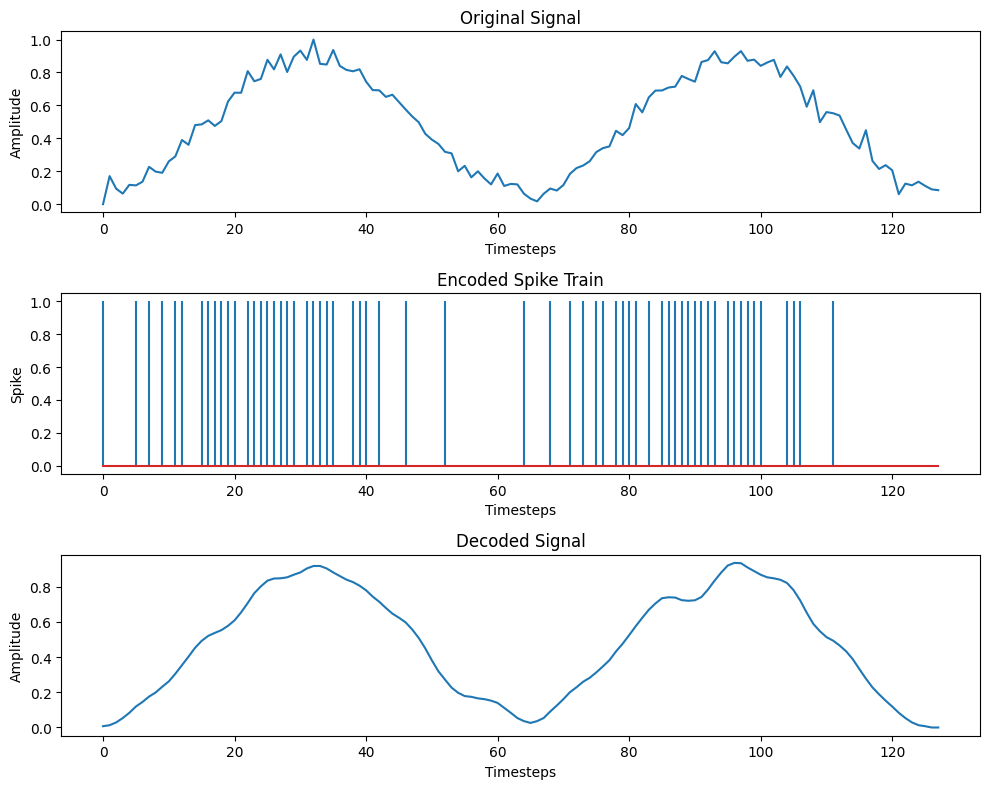

In [238]:
figs, axes = plt.subplots(3, 1, figsize=(10, 8))
figs.set_tight_layout(True)
axes[0].set_title("Original Signal")
axes[0].set_xlabel("Timesteps")
axes[0].set_ylabel("Amplitude")
sns.lineplot(normalized_data, ax=axes[0])
axes[1].set_title("Encoded Spike Train")
axes[1].set_xlabel("Timesteps")
axes[1].set_ylabel("Spike")
stemline = axes[1].stem(bsa_spikes, markerfmt="none")
axes[2].set_title("Decoded Signal")
axes[2].set_xlabel("Timesteps")
axes[2].set_ylabel("Amplitude")
sns.lineplot(bsa_decoded, ax=axes[2])

In [91]:
factor = 0.1
padding = torch.zeros_like(test_data.select(-1, 0).unsqueeze(-1))
diff = test_data.diff(dim=-1, prepend=padding)
threshold1 = torch.mean(diff, dim=-1, keepdim=True) + (torch.std(diff, dim=-1, keepdim=True) * factor)
pos_spikes = (diff > threshold1).float()
neg_spikes = (diff < -threshold1).float()
combined_spikes = pos_spikes - neg_spikes

In [92]:
decode = (combined_spikes.cumsum(dim=-1) * threshold1) + test_data.select(-1, 0).unsqueeze(-1)

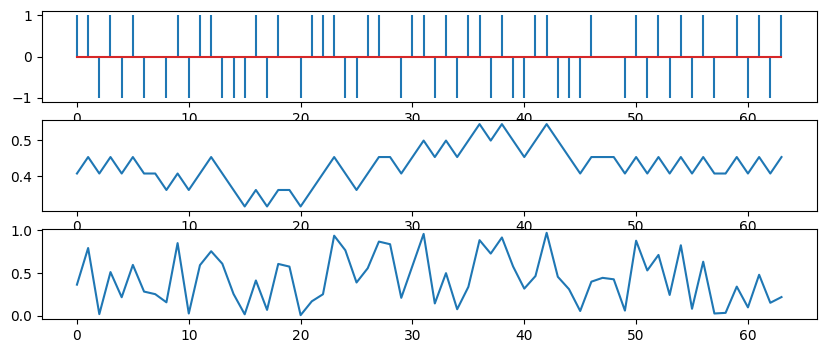

In [81]:
fig, axes = plt.subplots(3, 1, figsize=(10, 4))
axes[0].stem(combined_spikes[0, 0, 0, :], markerfmt="none")
axes[1].plot(decode[0, 0, 0, :])
axes[2].plot(test_data[0, 0, 0, :])

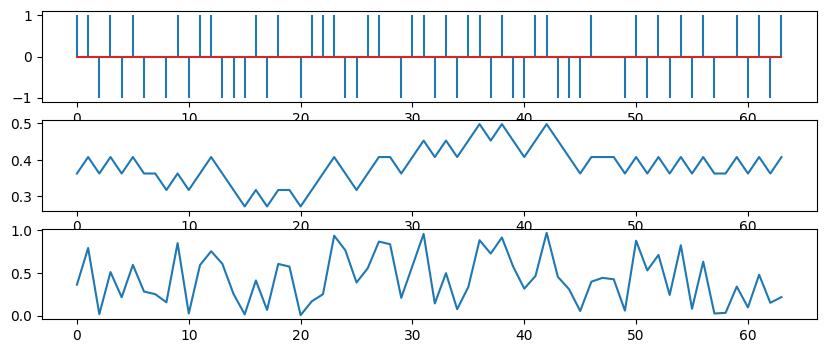

In [58]:
tbr_spikes = np.zeros_like(test_data[0,0,0,:])

data_diff = np.diff(test_data[0,0,0,:], prepend=0)
threshold = np.mean(data_diff) + 0.1 * np.std(data_diff)

for t, value in enumerate(data_diff):
    if value > threshold:
        tbr_spikes[t] = 1
    elif value < -threshold:
        tbr_spikes[t] = -1

tbr_decoded = np.zeros_like(tbr_spikes)
tbr_decoded[0] = test_data[0,0,0,:][0]
for t in range(1, len(tbr_spikes)):
    tbr_decoded[t] = tbr_decoded[t - 1] + (threshold * tbr_spikes[t])

fig, axes = plt.subplots(3, 1, figsize=(10, 4))
axes[0].stem(tbr_spikes, markerfmt="none")
axes[1].plot(tbr_decoded)
axes[2].plot(test_data[0, 0, 0, :])

In [77]:
decode[0, 0, 0, :]

tensor([0.4082, 0.4536, 0.4082, 0.4536, 0.4082, 0.4536, 0.4082, 0.4082, 0.3628,
        0.4082, 0.3628, 0.4082, 0.4536, 0.4082, 0.3628, 0.3174, 0.3628, 0.3174,
        0.3628, 0.3628, 0.3174, 0.3628, 0.4082, 0.4536, 0.4082, 0.3628, 0.4082,
        0.4536, 0.4536, 0.4082, 0.4536, 0.4991, 0.4536, 0.4991, 0.4536, 0.4991,
        0.5445, 0.4991, 0.5445, 0.4991, 0.4536, 0.4991, 0.5445, 0.4991, 0.4536,
        0.4082, 0.4536, 0.4536, 0.4536, 0.4082, 0.4536, 0.4082, 0.4536, 0.4082,
        0.4536, 0.4082, 0.4536, 0.4082, 0.4082, 0.4536, 0.4082, 0.4536, 0.4082,
        0.4536])

In [62]:
tbr_decoded

array([0.36279744, 0.40788746, 0.36279744, 0.40788746, 0.36279744,
       0.40788746, 0.36279744, 0.36279744, 0.31770742, 0.36279744,
       0.31770742, 0.36279744, 0.40788746, 0.36279744, 0.31770742,
       0.2726174 , 0.31770742, 0.2726174 , 0.31770742, 0.31770742,
       0.2726174 , 0.31770742, 0.36279744, 0.40788746, 0.36279744,
       0.31770742, 0.36279744, 0.40788746, 0.40788746, 0.36279744,
       0.40788746, 0.45297748, 0.40788746, 0.45297748, 0.40788746,
       0.45297748, 0.4980675 , 0.45297748, 0.4980675 , 0.45297748,
       0.40788746, 0.45297748, 0.4980675 , 0.45297748, 0.40788746,
       0.36279744, 0.40788746, 0.40788746, 0.40788746, 0.36279744,
       0.40788746, 0.36279744, 0.40788746, 0.36279744, 0.40788746,
       0.36279744, 0.40788746, 0.36279744, 0.36279744, 0.40788746,
       0.36279744, 0.40788746, 0.36279744, 0.40788746], dtype=float32)

In [ ]:
def tbr_encode_decode(data, factor=0.5):
    tbr_spikes = np.zeros_like(data)

    data_diff = np.diff(data)
    threshold = np.mean(data_diff) + factor * np.std(data_diff)
    data_diff = np.insert(data_diff, 0, data_diff[1])

    for t, value in enumerate(data_diff):
        if value > threshold:
            tbr_spikes[t] = 1
        elif value < -threshold:
            tbr_spikes[t] = -1

    # Decoding phase
    tbr_decoded = np.zeros_like(tbr_spikes)
    tbr_decoded[0] = data[0]
    for t in range(1, len(tbr_spikes)):
        tbr_decoded[t] = tbr_decoded[t - 1] + (threshold * tbr_spikes[t])

    return tbr_spikes, tbr_decoded

In [ ]:
def objective(trial: optuna.Trial) -> float:
    factor = trial.suggest_float("factor", 0.1, 2.0)

    _, tbr_decoded = tbr_encode_decode(normalized_data, factor=factor)

    # Calculate loss (Mean Squared Error)
    loss = np.mean((tbr_decoded - normalized_data) ** 2)
    return loss


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2025-04-07 01:42:21,581] A new study created in memory with name: no-name-d80975fb-a854-4df4-a63f-8bc7b4e1cb0e
[I 2025-04-07 01:42:21,582] Trial 0 finished with value: 0.3241285775537164 and parameters: {'threshold': 0.3082821065333172}. Best is trial 0 with value: 0.3241285775537164.
[I 2025-04-07 01:42:21,584] Trial 1 finished with value: 0.054688650497262806 and parameters: {'threshold': 0.09650272976771465}. Best is trial 1 with value: 0.054688650497262806.
[I 2025-04-07 01:42:21,585] Trial 2 finished with value: 0.3241285775537164 and parameters: {'threshold': 0.3925525754945972}. Best is trial 1 with value: 0.054688650497262806.
[I 2025-04-07 01:42:21,586] Trial 3 finished with value: 0.25946408906698737 and parameters: {'threshold': 0.14036135450515724}. Best is trial 1 with value: 0.054688650497262806.
[I 2025-04-07 01:42:21,587] Trial 4 finished with value: 0.3241285775537164 and parameters: {'threshold': 0.27571696537822504}. Best is trial 1 with value: 0.05468865049726280

In [ ]:
tbr_spikes, tbr_decoded = tbr_encode_decode(
    normalized_data, factor=study.best_trial.params["factor"]
)

<Axes: title={'center': 'Decoded Signal'}, xlabel='Timesteps', ylabel='Amplitude'>

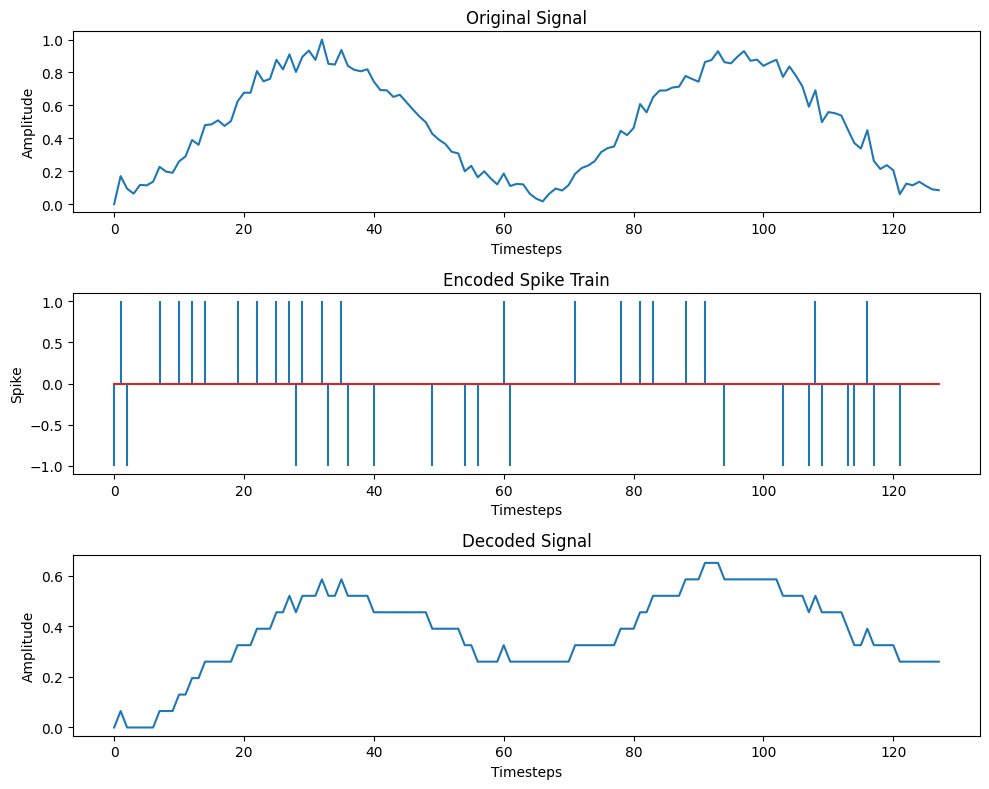

In [270]:
figs, axes = plt.subplots(3, 1, figsize=(10, 8))
figs.set_tight_layout(True)
axes[0].set_title("Original Signal")
axes[0].set_xlabel("Timesteps")
axes[0].set_ylabel("Amplitude")
sns.lineplot(normalized_data, ax=axes[0])
axes[1].set_title("Encoded Spike Train")
axes[1].set_xlabel("Timesteps")
axes[1].set_ylabel("Spike")
stemline = axes[1].stem(tbr_spikes, markerfmt="none")
axes[2].set_title("Decoded Signal")
axes[2].set_xlabel("Timesteps")
axes[2].set_ylabel("Amplitude")
sns.lineplot(tbr_decoded, ax=axes[2])